In [1]:
%%capture
!pip install datasets torchvision
!pip install git+https://github.com/huggingface/transformers

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_json('/content/drive/MyDrive/HN/M2/phil_comp/odil-data-master-hn/data/image_indexing_modified_openai.json')

In [5]:
filtro = (df['files'].str[-3:] =='jpg') | (df['files'].str[-3:] =='JPG')
df = df[filtro]

In [6]:
import json
df['openai_caption_raw'] = df['openai_caption_raw'].apply(json.loads)

In [7]:
df['openai_caption'] = df['openai_caption_raw'].apply(lambda x: x['caption'])

In [8]:
df = df[['files', 'openai_caption']]

In [9]:
from sklearn.model_selection import train_test_split

# Split 80% train / 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [10]:
from datasets import Dataset, DatasetDict, Features, Value, Image
import os

In [11]:
#from PIL import Image

In [12]:
os.chdir('/content/drive/MyDrive/HN/M2/phil_comp/odil-data-master-hn')

In [13]:
features = Features({
    "files": Image(),  # lazy loading
    "openai_caption": Value(dtype="string")
})

In [14]:
train_dataset = Dataset.from_pandas(train_df,
                                    features=features,
                                    preserve_index=False)

In [15]:
test_dataset = Dataset.from_pandas(test_df, features=features, preserve_index=False)

In [16]:
#from PIL import Image
#def load_images(example):
 #   example["files"] = Image.open(example["files"]).convert("RGB")
  #  return example

#train_dataset = train_dataset.map(load_images)
#test_dataset = test_dataset.map(load_images)

# Crea DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# Load model

In [17]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base", trust_remote_code=True)

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [18]:
def run_example(task_prompt, text_input, image):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer

In [19]:
task ="<MORE_DETAILED_CAPTION>"

Generated Description: {'<MORE_DETAILED_CAPTION>': 'The image is a medieval illustration of two knights engaged in a battle. The knight on the left is wearing a red robe and is holding a sword in his right hand, while the knight in the blue suit is standing on the right side of the image. They are both holding swords and appear to be in the midst of a fierce battle.\n\nIn the background, there is a castle with a red roof and a statue of a woman standing on top of it. The castle is surrounded by trees and there are mountains in the distance. The sky is blue and the ground is covered in greenery. The image is framed by a gold border with intricate designs and text. The text on the image is written in French and appears to be from a medieval manuscript.'}


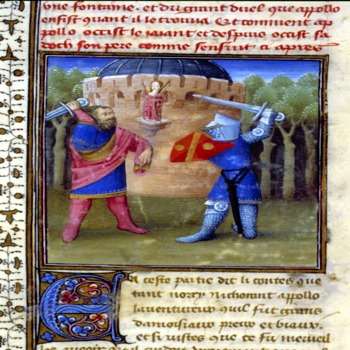

Generated Description: {'<MORE_DETAILED_CAPTION>': 'The image is an illustration of the Virgin Mary and Child Jesus standing in front of a pink archway. The archway is decorated with intricate designs and patterns in blue, red, and gold colors. The Virgin Mary is wearing a pink robe and is holding the baby Jesus in her arms. She is standing on the left side of the archway, while the Child Jesus is on the right side. \n\nIn the center of the image, there is a man wearing a blue robe and holding a staff. He is standing next to a woman wearing a red robe. The man is holding a book in his hands and appears to be reading from it.\n\nOn the top left corner, there are two angels, one on either side of Mary, and the other on the bottom right corner. The background is a blue sky with white clouds. The overall style of the illustration is ornate and detailed, with a mix of geometric shapes and floral motifs.'}


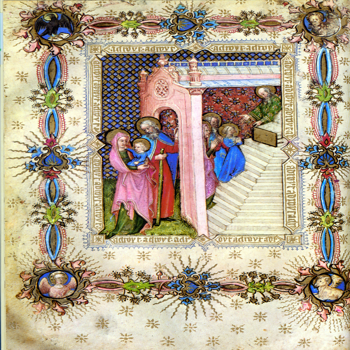

In [20]:
for idx in range(2):
    image = dataset_dict['test'][idx]['files']
    description = run_example(task, '', image)
    print(f"Generated Description: {description}")
    display(image.resize([350, 350]))

# Finetuning

In [21]:
from torch.utils.data import Dataset

class MedievalIllustration(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        prompt = "<MORE_DETAILED_CAPTION>"
        description = example['openai_caption']
        image = example['files']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return prompt, description, image

In [22]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm

In [23]:
train_dataset = MedievalIllustration(dataset_dict['train'])
test_dataset = MedievalIllustration(dataset_dict['test'])

In [24]:
def collate_fn(batch):
    prompts, descriptions, images = zip(*batch)
    inputs = processor(text=list(prompts), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, descriptions

# Create DataLoader
batch_size = 6  #6
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [25]:
from transformers import get_scheduler
from torch.optim import AdamW

In [26]:
def train_model(train_loader, val_loader, model, processor, epochs=4, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs, descriptions = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=list(descriptions), return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, descriptions = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=list(descriptions), return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

In [27]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

train_model(train_loader, test_loader, model, processor, epochs=8, lr=1e-6)

Training Epoch 1/8: 100%|██████████| 618/618 [29:25<00:00,  2.86s/it]


Average Training Loss: 3.449640918318122


Validation Epoch 1/8: 100%|██████████| 155/155 [06:15<00:00,  2.42s/it]


Average Validation Loss: 2.3306595433142876


Training Epoch 2/8: 100%|██████████| 618/618 [12:19<00:00,  1.20s/it]


Average Training Loss: 2.209897055209262


Validation Epoch 2/8: 100%|██████████| 155/155 [01:55<00:00,  1.34it/s]


Average Validation Loss: 1.998049150743792


Training Epoch 3/8: 100%|██████████| 618/618 [12:19<00:00,  1.20s/it]


Average Training Loss: 1.9862023989359539


Validation Epoch 3/8: 100%|██████████| 155/155 [01:57<00:00,  1.32it/s]


Average Validation Loss: 1.900336633190032


Training Epoch 4/8: 100%|██████████| 618/618 [12:20<00:00,  1.20s/it]


Average Training Loss: 1.8914868158429958


Validation Epoch 4/8: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.8467947975281747


Training Epoch 5/8: 100%|██████████| 618/618 [12:20<00:00,  1.20s/it]


Average Training Loss: 1.827006100065114


Validation Epoch 5/8: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.8117732432580764


Training Epoch 6/8: 100%|██████████| 618/618 [12:20<00:00,  1.20s/it]


Average Training Loss: 1.7933131041650248


Validation Epoch 6/8: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.7891984493501725


Training Epoch 7/8: 100%|██████████| 618/618 [12:21<00:00,  1.20s/it]


Average Training Loss: 1.7660212049978066


Validation Epoch 7/8: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]


Average Validation Loss: 1.7791652733279812


Training Epoch 8/8: 100%|██████████| 618/618 [12:19<00:00,  1.20s/it]


Average Training Loss: 1.7448884451273576


Validation Epoch 8/8: 100%|██████████| 155/155 [01:56<00:00,  1.33it/s]

Average Validation Loss: 1.7749463596651631


Generated Description: {'<MORE_DETAILED_CAPTION>': 'In a serene landscape, a knight in shining armor stands guard, wielding a sword and shield, while a statue of Christ stands nearby, adorned with a coat of arms.'}


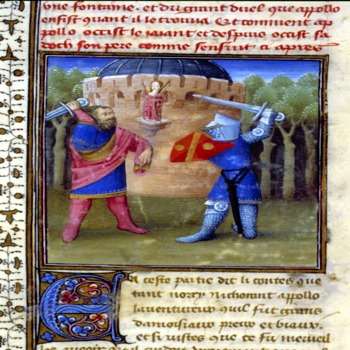

Generated Description: {'<MORE_DETAILED_CAPTION>': 'In the scene of the Adoration of the Magi, the Vierge stands beside a grand staircase, holding a crosier, while an angel watches over the scene, accompanied by a child and an angel.'}


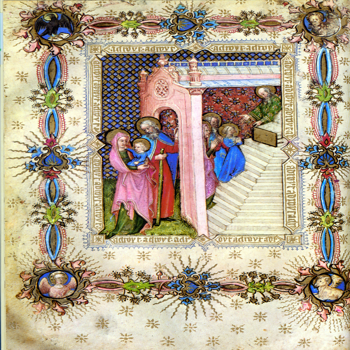

In [28]:
model.eval()
for idx in range(2):
    image = dataset_dict['test'][idx]['files']
    description = run_example(task, '', image)
    print(f"Generated Description: {description}")
    display(image.resize([350, 350]))

Original_desctiption: In a lush forest, a knight stands resolute beside a statue of Venus, adorned in armor and holding a sword; his shield, featuring a coat of arms, rests against the arcade's capital as he contemplates his next quest.


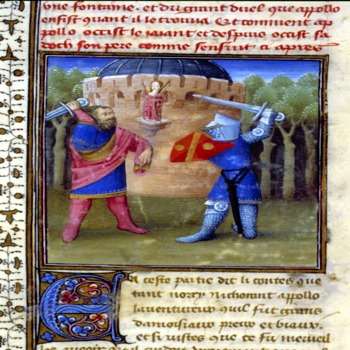

Original_desctiption: In the sacred scene of the presentation of the Virgin at the temple, Saint Anne and Saint Joachim stand beside the altar, while the Hebrew priest ascends the staircase, accompanied by the four evangelists portrayed as a lion, an ox, an eagle, and a man, with an angel observing the divine event.


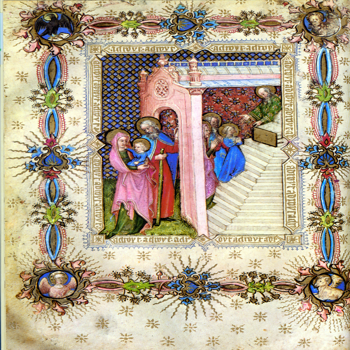

In [29]:
for idx in range(2):
    image = dataset_dict['test'][idx]['files']
    description = dataset_dict['test'][idx]['openai_caption']
    print(f"Original_desctiption: {description}")
    display(image.resize([350, 350]))

In [ ]:
from huggingface_hub import login

login('API_KEY')

In [32]:
model.config.vision_config.model_type = 'davit'

In [33]:
model.push_to_hub('francipaolo/florence-2-pal-comp-v2',private=True)
processor.push_to_hub('francipaolo/florence-2-pal-comp-v2', private=True)

README.md:   0%|          | 0.00/2.88k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.08G [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/francipaolo/florence-2-pal-comp-v2/commit/6c961ca303cad778b65c858bf3952fed8abd63f9', commit_message='Upload processor', commit_description='', oid='6c961ca303cad778b65c858bf3952fed8abd63f9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/francipaolo/florence-2-pal-comp-v2', endpoint='https://huggingface.co', repo_type='model', repo_id='francipaolo/florence-2-pal-comp-v2'), pr_revision=None, pr_num=None)